### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

# from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [4]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            # label.set_size(8)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [5]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [6]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [7]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "E"

In [8]:
df_E = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "E"].copy()
df_E

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
5,2021-01-04,DEVRYNALDO RIZAL,JL JEND A YANI,KARANG JATI,BALIKPAPAN TENGAH,LAKI-LAKI,1978-12-18,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SARJANA,ES5,E,INDIVIDU,46
7,2021-01-04,SUPARYANTO,JL KESATRIA PERUM NUSANTARA LESTARI,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1976-08-27,NaN,NaN,NaN,ES4,E,INSTANSI LUAR,48
14,2021-01-06,MULYADI,JL SYARIFUDIN YOES,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1974-12-23,Wiraswasta-Konstruksi,"> Rp. 6.000.000,-",SLTA/SMU,ES4,E,INDIVIDU,50
15,2021-01-06,MUHAMMAD FADILLAH,JL AL MAKMUR III,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1997-12-07,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTP/SMP,ES4,E,INDIVIDU,27
18,2021-01-06,ANDI WIJAYANTO,JL SUGENG RAWUH II,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-07-06,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ES5,E,INDIVIDU,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,2024-06-30,PT KEMILAU INDAH NUSANTARA,JL. POROS SANGATTA-BENGALON KM. 32,MUARA BENGALON,BENGALON,LAKI-LAKI,1985-06-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,EG2,E,INDIVIDU,39
6523,2024-07-12,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGALON KM 32 SIMPANG RAWA ...,MUARA BENGALON,BENGALON,NaN,2000-11-18,Wiraswasta-Pertambangan,NaN,NaN,EG2,E,INSTANSI LUAR,24
6833,2024-08-29,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGGALON KM 32 SIMPANG RAWA...,MUARA BENGALON,BENGALON,NaN,1992-08-27,NaN,NaN,NaN,EG2,E,INSTANSI LUAR,32
6841,2024-08-31,LINUS HARIMIN,JL BATU RATNA KM 11,KARANG JOANG,BALIKPAPAN UTARA,LAKI-LAKI,1973-09-23,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ESF,E,INDIVIDU,51


Plot data initial varian plus "E"

In [9]:
df_E_count = df_E[["Tgl. Mohon"]].copy()
df_E_count["count"] = 1.
df_E_count = df_E_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_E_count["cumulative_sum"] = df_E_count["count"].cumsum()
df_E_count["rolling_7days"] = df_E_count["count"].rolling(window=7, min_periods=1).sum()
df_E_count

,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-01-04,2,2,2.0
1,2021-01-06,3,5,5.0
2,2021-01-07,1,6,6.0
3,2021-01-14,1,7,7.0
4,2021-01-21,1,8,8.0
...,...,...,...,...
170,2024-06-05,1,421,21.0
171,2024-06-30,1,422,18.0
172,2024-07-12,1,423,15.0
173,2024-08-29,1,424,12.0


Groub by weekly

In [10]:
df_E_weekly = df_E_count[["Tgl. Mohon"]].copy()
df_E_count["Tgl. Mohon"] = pd.to_datetime(df_E_count["Tgl. Mohon"])

df_E_weekly = (df_E.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_E_weekly["cumulative_sum"] = df_E_weekly["count"].cumsum()
df_E_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,2,2
1,2021-01-11,4,6
2,2021-01-18,1,7
3,2021-01-25,1,8
4,2021-02-01,1,9
...,...,...,...
187,2024-08-05,0,423
188,2024-08-12,0,423
189,2024-08-19,0,423
190,2024-08-26,0,423


In [11]:
df_E_count.describe()

,Tgl. Mohon,count,cumulative_sum,rolling_7days
count,175,175.000000,175.000000,175.000000
mean,2022-10-28 14:40:27.428571392,2.434286,222.862857,16.885714
min,2021-01-04 00:00:00,1.000000,2.000000,2.000000
25%,2021-11-25 00:00:00,1.000000,106.500000,9.000000
50%,2022-12-26 00:00:00,1.000000,234.000000,12.000000
75%,2023-08-18 12:00:00,2.000000,358.500000,20.000000
max,2024-08-31 00:00:00,32.000000,426.000000,60.000000
std,NaN,4.381908,129.754293,12.674010


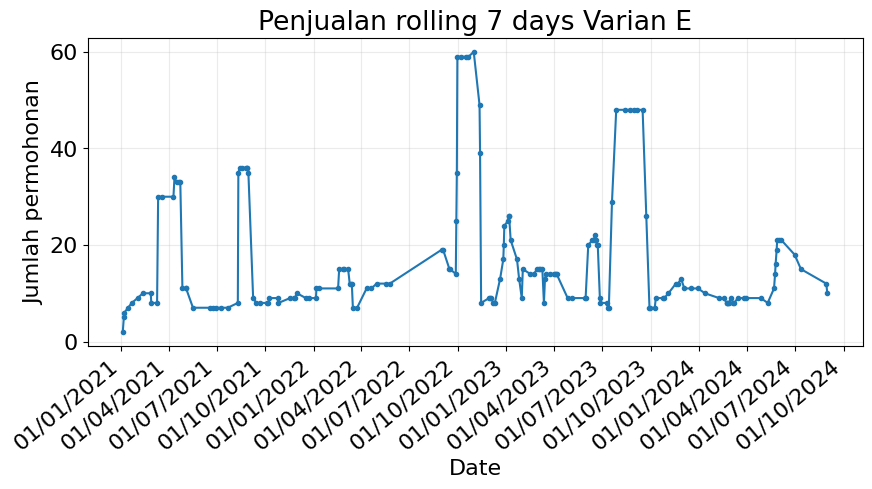

In [12]:
plot_time_series(df_E_count["Tgl. Mohon"], df_E_count["rolling_7days"], 
                title="Penjualan rolling 7 days Varian E",
                xlabel="Date", ylabel="Jumlah permohonan")

In [13]:
Q1 = df_E_count["rolling_7days"].quantile(0.25)
Q3 = df_E_count["rolling_7days"].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Deteksi dan tampilkan outlier
outliers = df_E_count[(df_E_count["rolling_7days"] < batas_bawah) | 
                      (df_E_count["rolling_7days"] > batas_atas)]
print(f"Jumlah outlier (rolling_7days) varian E: {len(outliers)}")
display(outliers)


Jumlah outlier (rolling_7days) varian E: 13


,Tgl. Mohon,count,cumulative_sum,rolling_7days
73,2022-09-30,32,209,59.0
74,2022-10-07,1,210,59.0
75,2022-10-17,1,211,59.0
76,2022-10-21,1,212,59.0
77,2022-10-31,2,214,60.0
78,2022-11-11,1,215,49.0
79,2022-11-12,1,216,39.0
129,2023-07-28,20,357,48.0
130,2023-08-14,1,358,48.0
131,2023-08-23,1,359,48.0


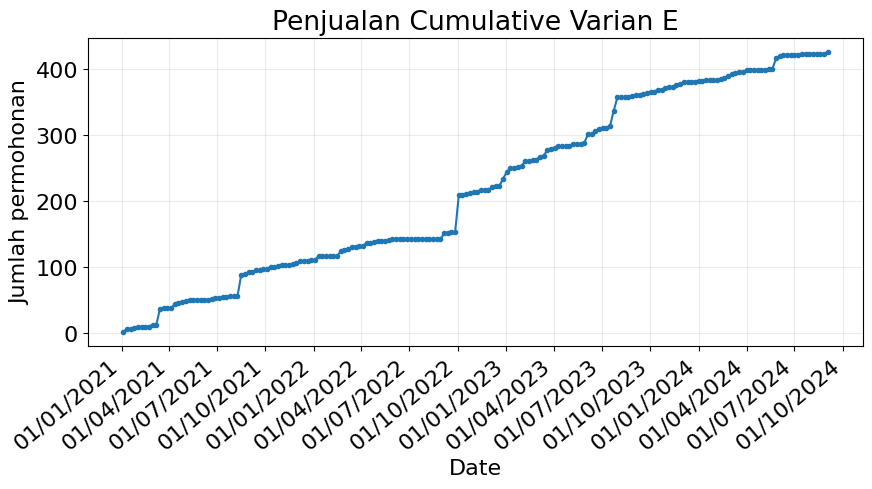

In [14]:
plot_time_series(df_E_weekly["Tgl. Mohon"], df_E_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian E",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [15]:
ADF_result = adfuller(df_E_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.5583566577354281
p-value: 0.8801168541331186


In [16]:
E_diff = np.diff(df_E_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(E_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -13.29064628909216
p-value: 7.374723524543663e-25


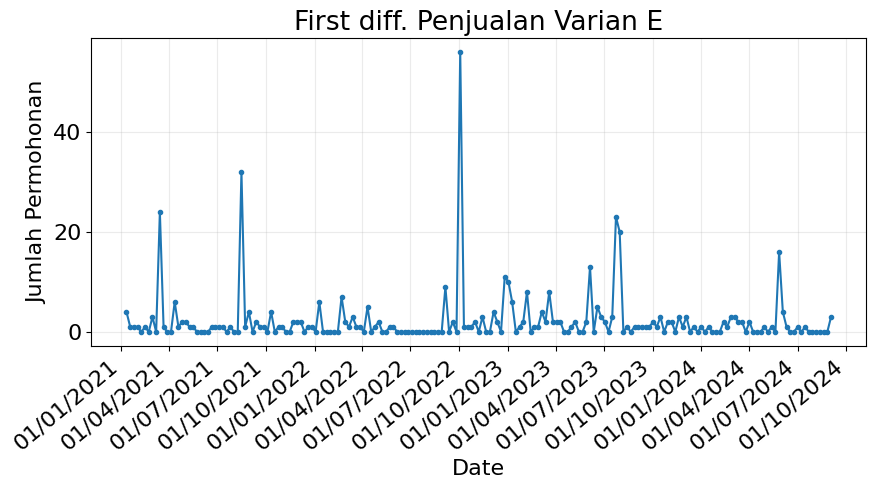

In [17]:
plot_time_series(df_E_weekly["Tgl. Mohon"].iloc[1:], E_diff, 
                 title="First diff. Penjualan Varian E",
                 xlabel="Date", ylabel="Jumlah Permohonan")

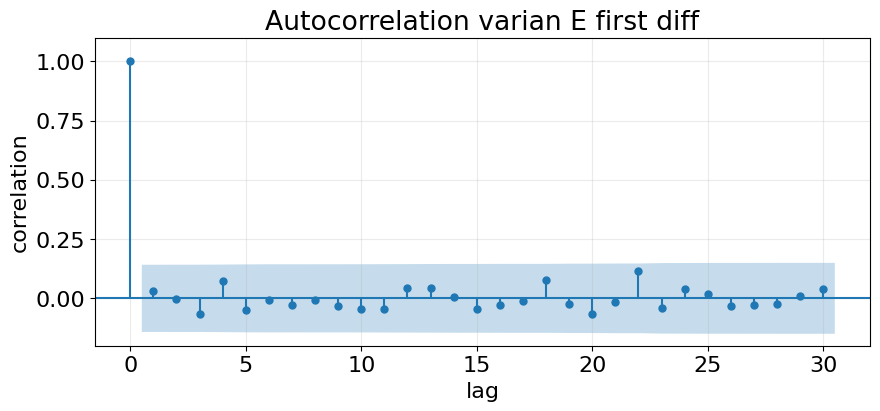

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(E_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian E first diff")
ax.grid("on")

plt.show(fig)

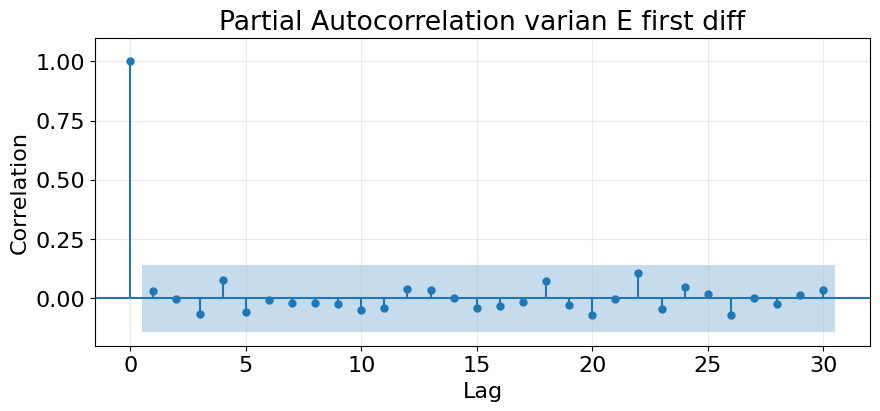

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(E_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian E first diff")
ax.grid("on")

plt.show()

#### harian

In [20]:
ADF_result = adfuller(df_E_count["rolling_7days"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.3999000744356516
p-value: 0.14176461392554557


fisrt diff (_d_=1)

In [21]:
E_diff = np.diff(df_E_count["rolling_7days"], n=1)
ADF_result = adfuller(E_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -6.329633538447839
p-value: 2.927912568440384e-08


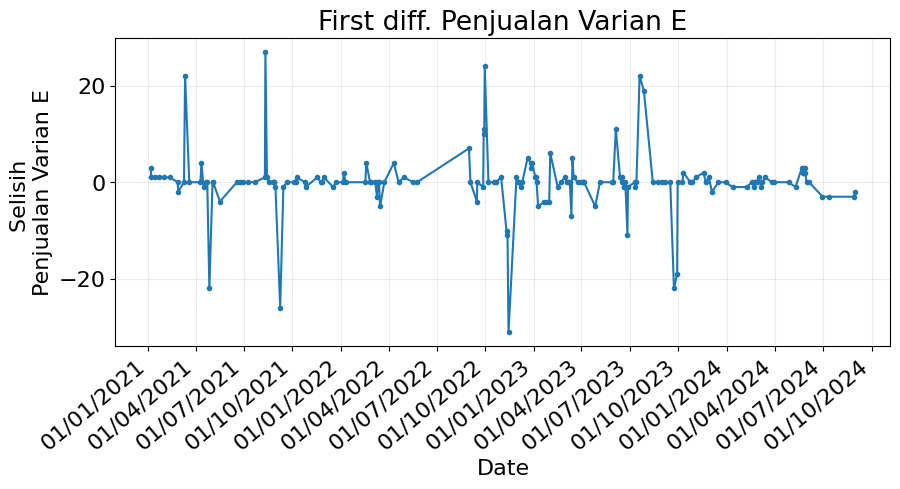

In [22]:
plot_time_series(df_E_count["Tgl. Mohon"].iloc[1:], E_diff, 
                 title="First diff. Penjualan Varian E",
                 xlabel="Date", ylabel="Selisih \nPenjualan Varian E")

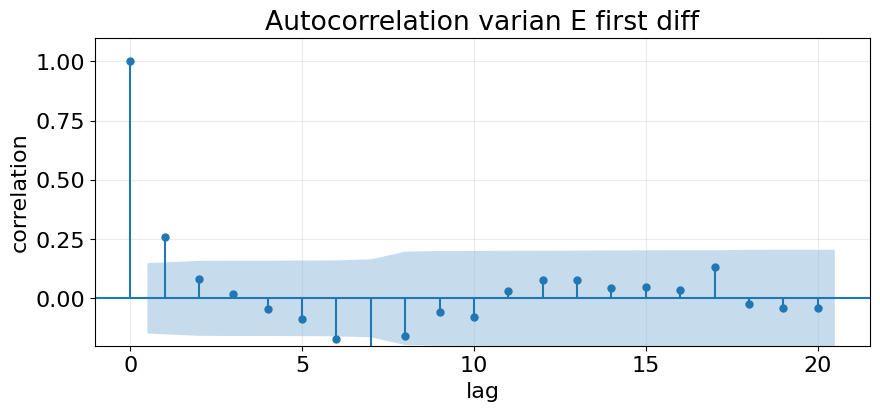

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(E_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian E first diff")
ax.grid("on")

plt.show(fig)

MA(1)

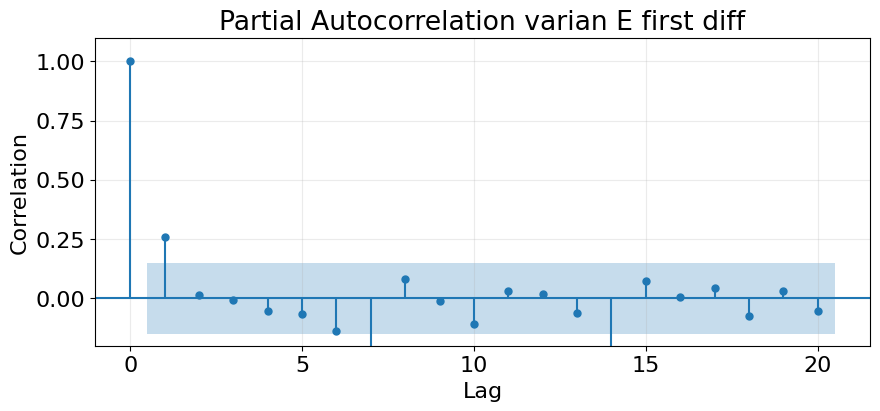

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(E_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian E first diff")
ax.grid("on")

plt.show()

AR(1)

### Data Splitting

In [25]:
df_E_diff = pd.DataFrame({
    "Tgl. Mohon": df_E_count["Tgl. Mohon"].iloc[1:],
    "E_diff": E_diff})

split_idx = int(0.8 * len(df_E_diff))
df_train = df_E_diff.iloc[:split_idx].copy()
df_test = df_E_diff.iloc[split_idx:].copy()


print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (139, 35)


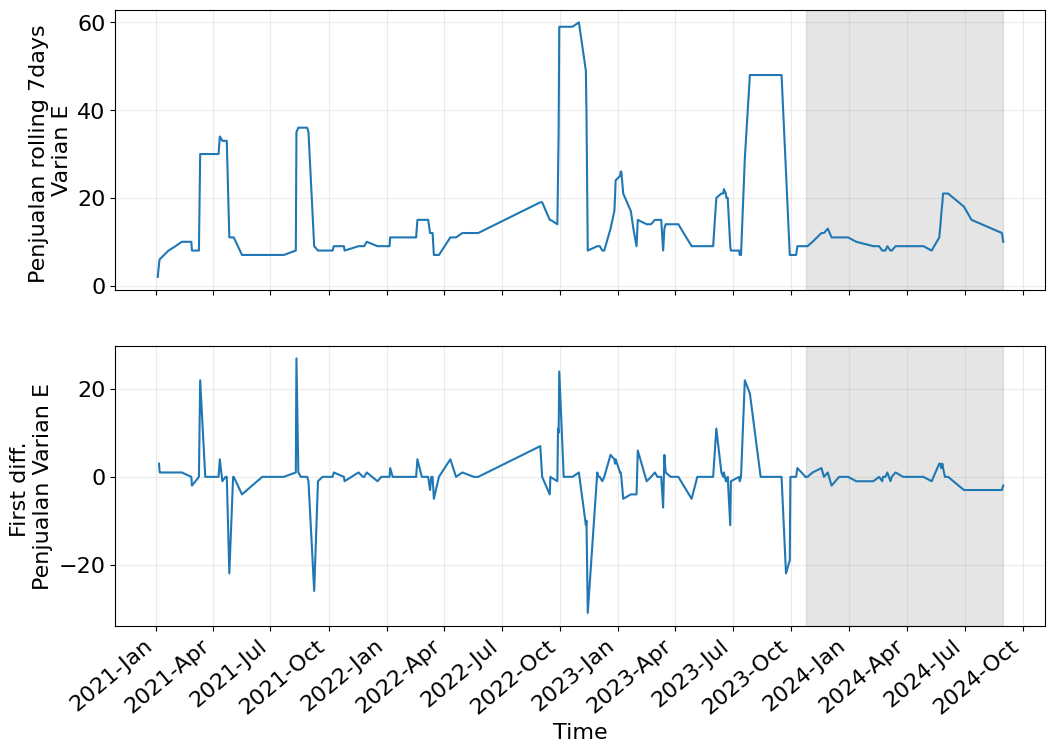

In [26]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# -- first row
axes[0].plot(df_E_count["Tgl. Mohon"], df_E_count["rolling_7days"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian E")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian E")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### MA (1) AR(1)

In [27]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["E_diff"])
      pred_mean.extend(mean for _ in range(window))
    # print(len(pred_mean), horizon)
    if len(pred_mean) > horizon:  # cut over counting in (mean for _ in range(window))
      pred_mean = pred_mean[:horizon]

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["E_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    if len(pred_last_value) > horizon:  # cut over counting in (last_value for _ in range(window))
      pred_last_value = pred_last_value[:horizon]

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["E_diff"], order=(0, 1))
      model = SARIMAX(df[:i]["E_diff"], order=(0, 0, 1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    if len(pred_MA) > horizon:  # cut over counting in (.iloc[-window:])
      pred_MA = pred_MA[:horizon]

    return pred_MA

  elif method == "AR":
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i]["E_diff"], order=(1, 0, 0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_AR.extend(oos_pred)

    return pred_AR

In [28]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 7

pred_mean = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")
pred_AR = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "AR")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA
pred_df["pred_AR"] = pred_AR

pred_df

,Tgl. Mohon,E_diff,pred_mean,pred_last_value,pred_MA,pred_AR
140,2023-10-24,0.0,0.050360,2.0,0.512427,0.506138
141,2023-10-27,0.0,0.050360,2.0,0.000000,0.128088
142,2023-11-04,1.0,0.050360,2.0,0.000000,0.032415
143,2023-11-18,2.0,0.050360,2.0,0.000000,0.008203
144,2023-11-22,0.0,0.050360,2.0,0.000000,0.002076
145,2023-11-28,1.0,0.050360,2.0,0.000000,0.000525
146,2023-12-04,-2.0,0.050360,2.0,0.000000,0.000133
147,2023-12-16,0.0,0.061644,-2.0,-0.529717,-0.505557
148,2023-12-30,0.0,0.061644,-2.0,0.000000,-0.127794
149,2024-01-12,-1.0,0.061644,-2.0,0.000000,-0.032304


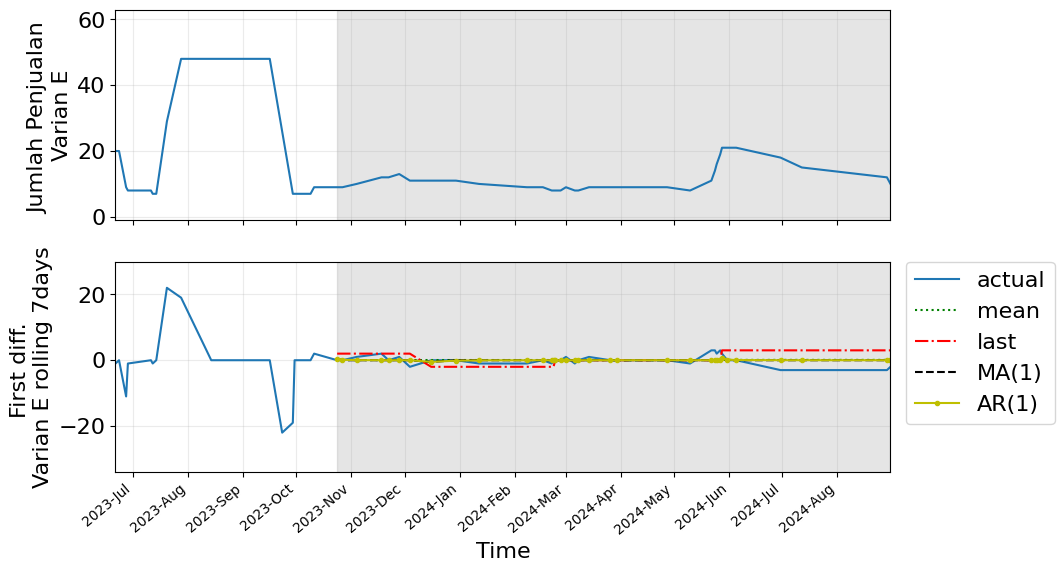

In [29]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian E rolling 7days")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size (10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["rolling_7days"])

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Penjualan \nVarian E")
axes[0].set_xlim(xlim)


plt.show(fig)

In [30]:
mse_mean = mean_squared_error(pred_df["E_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["E_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["E_diff"], pred_df["pred_MA"])
mse_AR = mean_squared_error(pred_df["E_diff"], pred_df["pred_AR"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")
print(f"MSE AR: {mse_AR}")

MSE mean: 2.4053823328751185
MSE last: 6.742857142857143
MSE MA: 2.326812279076755
MSE AR: 2.3153400343606205


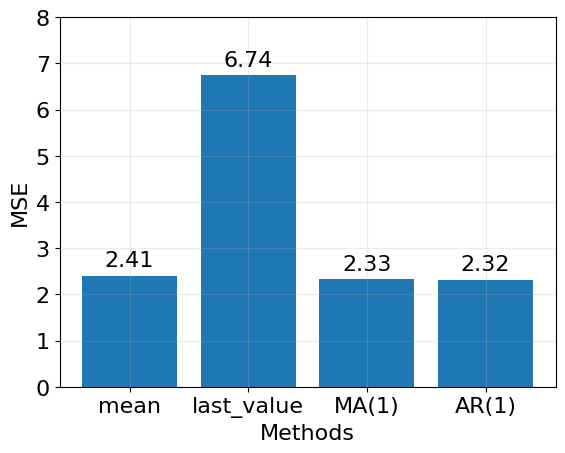

In [31]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean, mse_last, mse_MA, mse_AR]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 8])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [32]:
idx_y0 = len(df_train) + 1 
y0 = df_E_count.iloc[idx_y0]["rolling_7days"]
# print(y0)
df_test_E = df_E_count[idx_y0:].copy()
df_test_E["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
df_test_E["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
df_test_E["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
df_test_E["pred_AR"] = y0 + pred_df["pred_AR"].cumsum()
df_test_E.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_last_value,pred_MA,pred_AR
140,2023-10-24,1,370,9.0,9.050360,11.0,9.512427,9.506138
141,2023-10-27,1,371,9.0,9.100719,13.0,9.512427,9.634225
142,2023-11-04,2,373,10.0,9.151079,15.0,9.512427,9.666640
143,2023-11-18,3,376,12.0,9.201439,17.0,9.512427,9.674844
144,2023-11-22,1,377,12.0,9.251799,19.0,9.512427,9.676920


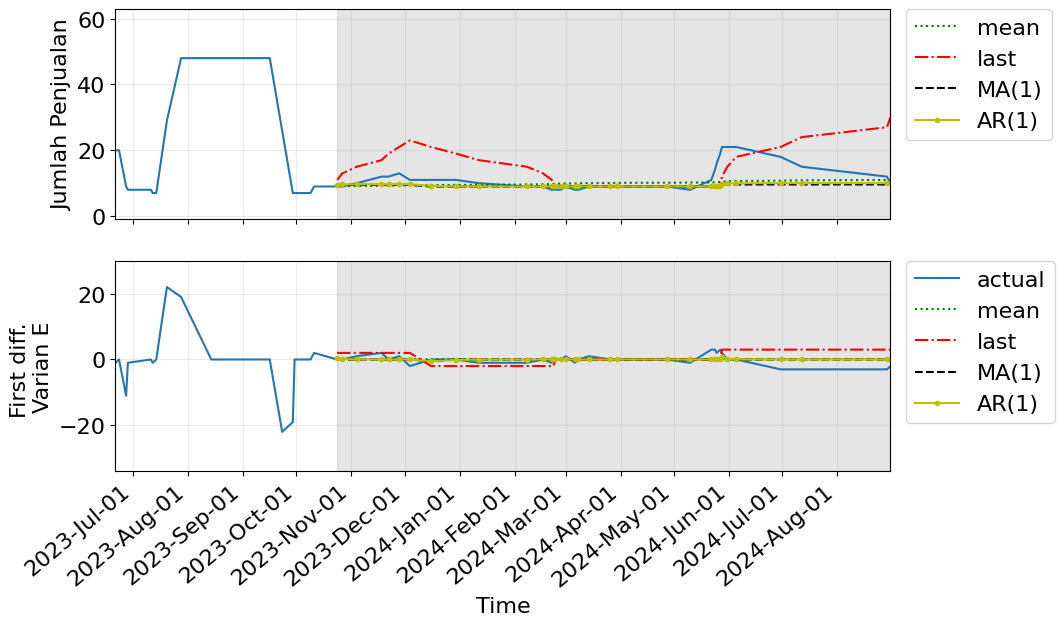

In [33]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian E")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["rolling_7days"])

# -- prediction for the original data
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_MA"], "k--", label="MA(1)")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_AR"], "y.-", label="AR(1)")

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Penjualan")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)

### Evaluasi MA(1) AR(1)

MAE

In [34]:
mae_mean_undiff = mean_absolute_error(df_test_E["rolling_7days"], df_test_E["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_E["rolling_7days"], df_test_E["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(df_test_E["rolling_7days"], df_test_E["pred_MA"])
mae_AR_undiff   = mean_absolute_error(df_test_E["rolling_7days"], df_test_E["pred_AR"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")
print(f"MAE AR: {mae_AR_undiff}")

MAE mean: 2.8231288917969835
MAE last: 5.0285714285714285
MAE MA: 2.8157397271296305
MAE AR: 2.7079638960255936


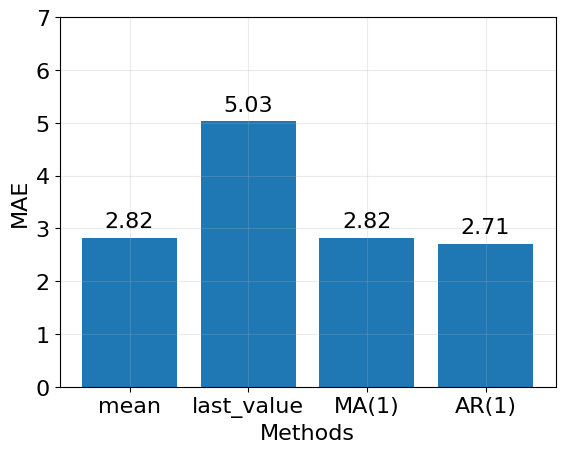

In [35]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff, mae_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 7])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [36]:
mse_mean_undiff = mean_squared_error(df_test_E["rolling_7days"], df_test_E["pred_mean"])
mse_last_undiff = mean_squared_error(df_test_E["rolling_7days"], df_test_E["pred_last_value"])
mse_MA_undiff   = mean_squared_error(df_test_E["rolling_7days"], df_test_E["pred_MA"])
mse_AR_undiff   = mean_squared_error(df_test_E["rolling_7days"], df_test_E["pred_AR"])

print(f"MSE mean: {mse_mean_undiff}")
print(f"MSE last: {mse_last_undiff}")
print(f"MSE MA: {mse_MA_undiff}")
print(f"MSE AR: {mse_AR_undiff}")

MSE mean: 16.814311490272285
MSE last: 46.457142857142856
MSE MA: 20.47248358106634
MSE AR: 19.394393411007478


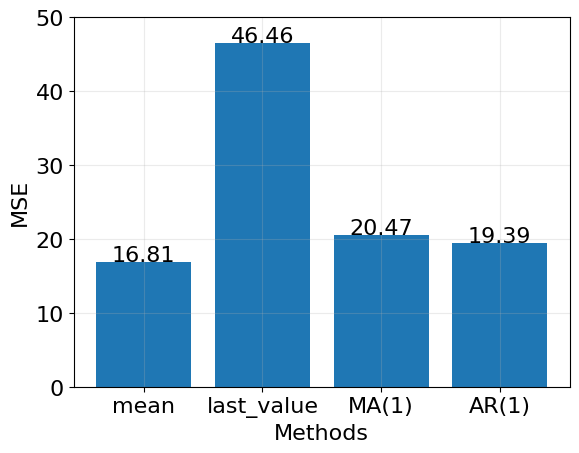

In [37]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean_undiff, mse_last_undiff, mse_MA_undiff, mse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 50])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [38]:
rmse_mean_undiff = np.sqrt(mse_mean_undiff)
rmse_last_undiff = np.sqrt(mse_last_undiff)
rmse_MA_undiff = np.sqrt(mse_MA_undiff)
rmse_AR_undiff = np.sqrt(mse_AR_undiff)

print(f"RMSE mean: {rmse_mean_undiff}")
print(f"RMSE last: {rmse_last_undiff}")
print(f"RMSE MA: {rmse_MA_undiff}")
print(f"RMSE AR: {rmse_AR_undiff}")

RMSE mean: 4.100525757786712
RMSE last: 6.81594768591594
RMSE MA: 4.524652868570841
RMSE AR: 4.403906607888896


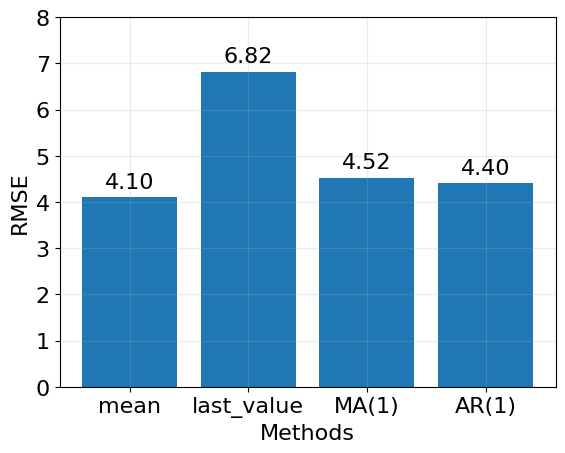

In [39]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [rmse_mean_undiff, rmse_last_undiff, rmse_MA_undiff, rmse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 8])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [40]:
mape_mean_undiff = mean_absolute_percentage_error(df_test_E["rolling_7days"], df_test_E["pred_mean"]) * 100
mape_last_undiff = mean_absolute_percentage_error(df_test_E["rolling_7days"], df_test_E["pred_last_value"]) * 100
mape_MA_undiff   = mean_absolute_percentage_error(df_test_E["rolling_7days"], df_test_E["pred_MA"]) * 100
mape_AR_undiff   = mean_absolute_percentage_error(df_test_E["rolling_7days"], df_test_E["pred_AR"]) * 100

print(f"MAPE mean: {mape_mean_undiff:.2f}%")
print(f"MAPE last: {mape_last_undiff:.2f}%")
print(f"MAPE MA: {mape_MA_undiff:.2f}%")
print(f"MAPE AR: {mape_AR_undiff:.2f}%")

MAPE mean: 20.62%
MAPE last: 42.35%
MAPE MA: 18.72%
MAPE AR: 17.92%


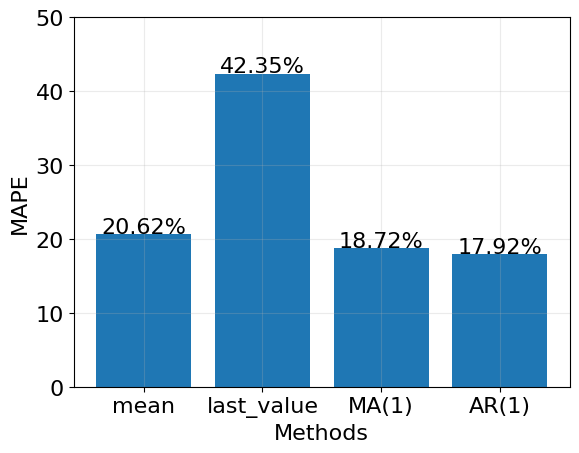

In [41]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mape_mean_undiff, mape_last_undiff, mape_MA_undiff, mape_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 50])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [42]:
naive = np.abs(np.diff(df_test_E["rolling_7days"])).mean()

mase_mean_undiff = mae_mean_undiff / naive
mase_last_undiff = mae_last_undiff / naive
mase_MA_undiff   = mae_MA_undiff / naive
mase_AR_undiff   = mae_AR_undiff / naive

print(f"MASE mean: {mase_mean_undiff}")
print(f"MASE last: {mase_last_undiff}")
print(f"MASE MA: {mase_MA_undiff}")
print(f"MASE AR: {mase_AR_undiff}")

MASE mean: 2.59422654921885
MASE last: 4.620849420849421
MASE MA: 2.587436506011012
MASE AR: 2.4883992558073023


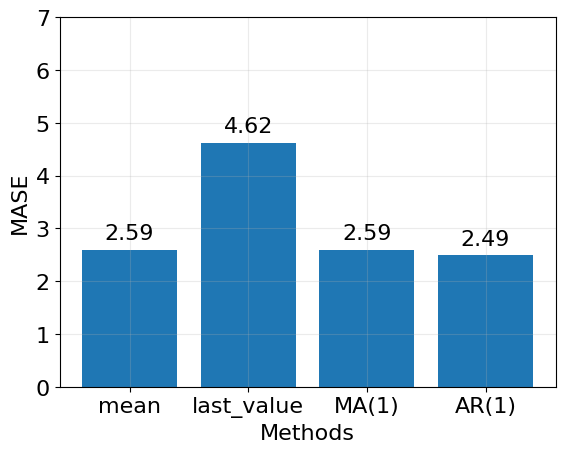

In [43]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mase_mean_undiff, mase_last_undiff, mase_MA_undiff, mase_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 7])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Data Splitting ARIMA

In [44]:
split_idx = int(0.8 * len(df_E_count))
df_train_arima = df_E_count.iloc[:split_idx].copy()
df_test_arima = df_E_count.iloc[split_idx:].copy()

print(f"(len(df_train_arima), len(df_test_arima)): {len(df_train_arima), len(df_test_arima)}")


(len(df_train_arima), len(df_test_arima)): (140, 35)


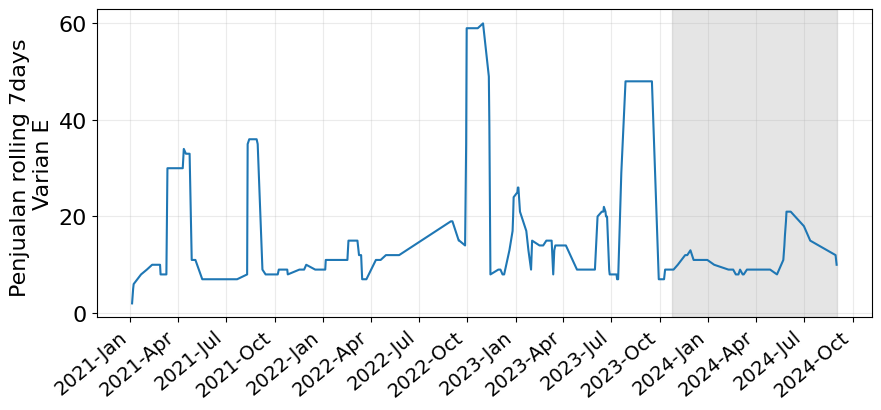

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_E_count['Tgl. Mohon'], df_E_count["rolling_7days"])
ax.grid("on")
ax.set_ylabel("Penjualan rolling 7days \nVarian E")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (2,1,1)

In [46]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [47]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 1

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [48]:
result_df = optimize_ARIMA(df_train_arima["rolling_7days"], order_list, d,
                            enforce_invertibility=True,
                            enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0)
(2, 1)
(2, 2)


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 3)


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0)
(3, 1)
(3, 2)


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

(3, 3)


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(3, 2)",916.460413
1,"(2, 3)",918.359184
2,"(3, 3)",919.388213
3,"(1, 2)",924.194903
4,"(1, 0)",929.398693
5,"(0, 1)",930.129187
6,"(2, 0)",931.374761
7,"(1, 1)",931.376311
8,"(0, 2)",931.471475
9,"(2, 1)",932.692244


In [49]:
best_p, best_q = (3, 2)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (3, 2)


In [50]:
model_arima_best = SARIMAX(df_train_arima["rolling_7days"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


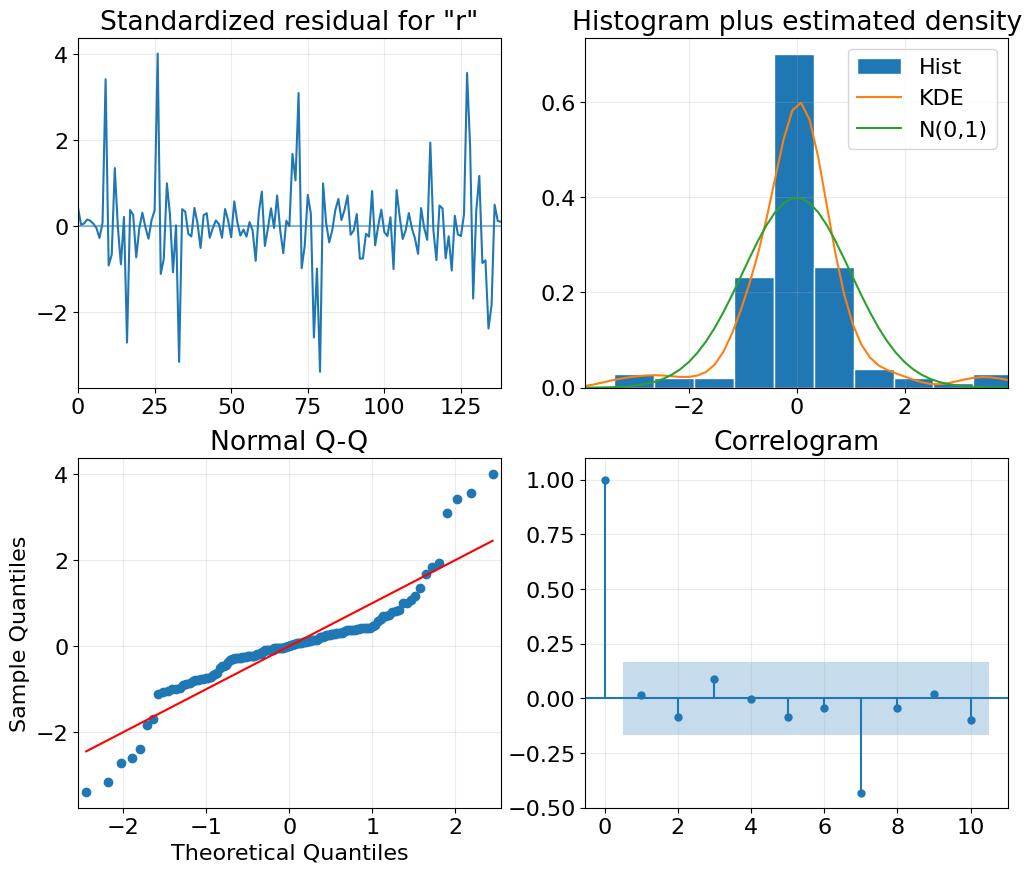

In [51]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [52]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.015959,0.899472
2,1.049002,0.591851
3,2.302381,0.512065
4,2.303948,0.680050
5,3.362714,0.644255
6,3.602411,0.730298
7,31.384941,0.000053
8,31.643521,0.000108
9,31.714123,0.000223
10,33.034749,0.000269


_p-value_ > 0.05 untuk semua lag, maka tidak ada autokorelasi dalam residual. Artiinya model menangkap semua pola dalam data

In [53]:
df_test_pred_arima = df_test_arima.copy()

TRAIN_LEN = len(df_train_arima)
HORIZON = len(df_test_arima)

pred_mean = np.ones(HORIZON)*np.mean(df_train_arima["rolling_7days"])
pred_naive_seasonal = df_train_arima["rolling_7days"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred_arima["pred_mean"] = pred_mean
df_test_pred_arima["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred_arima["pred_arima"] = pred_arima

df_test_pred_arima.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_naive_seasonal,pred_arima
140,2023-10-24,1,370,9.0,18.214286,13.0,9.732542
141,2023-10-27,1,371,9.0,18.214286,14.0,9.052305
142,2023-11-04,2,373,10.0,18.214286,14.0,8.932751
143,2023-11-18,3,376,12.0,18.214286,14.0,9.440364
144,2023-11-22,1,377,12.0,18.214286,14.0,9.359578


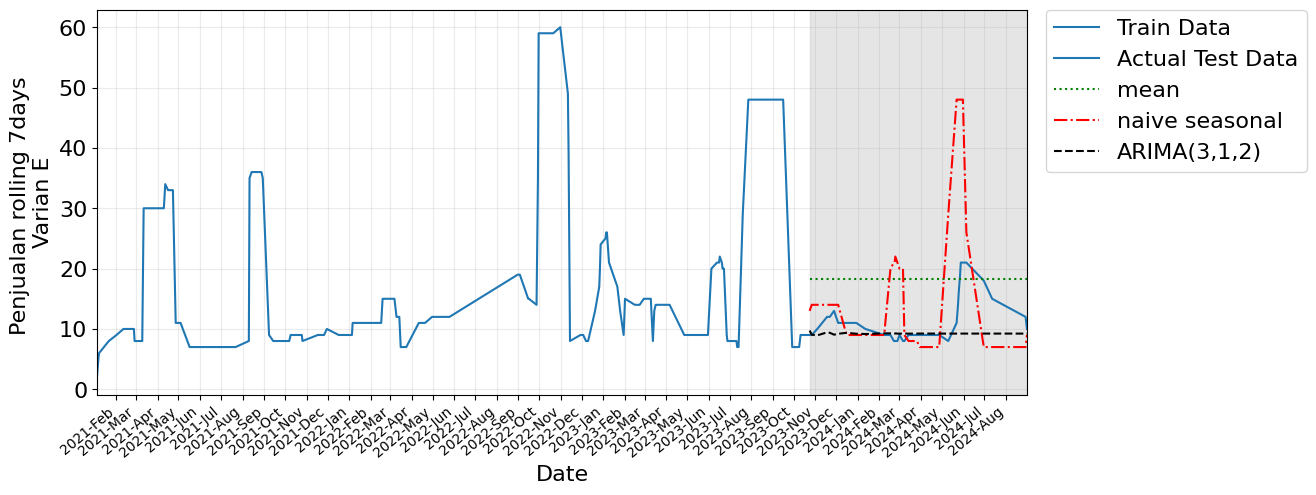

In [54]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 0  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["rolling_7days"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["rolling_7days"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian E")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--",
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

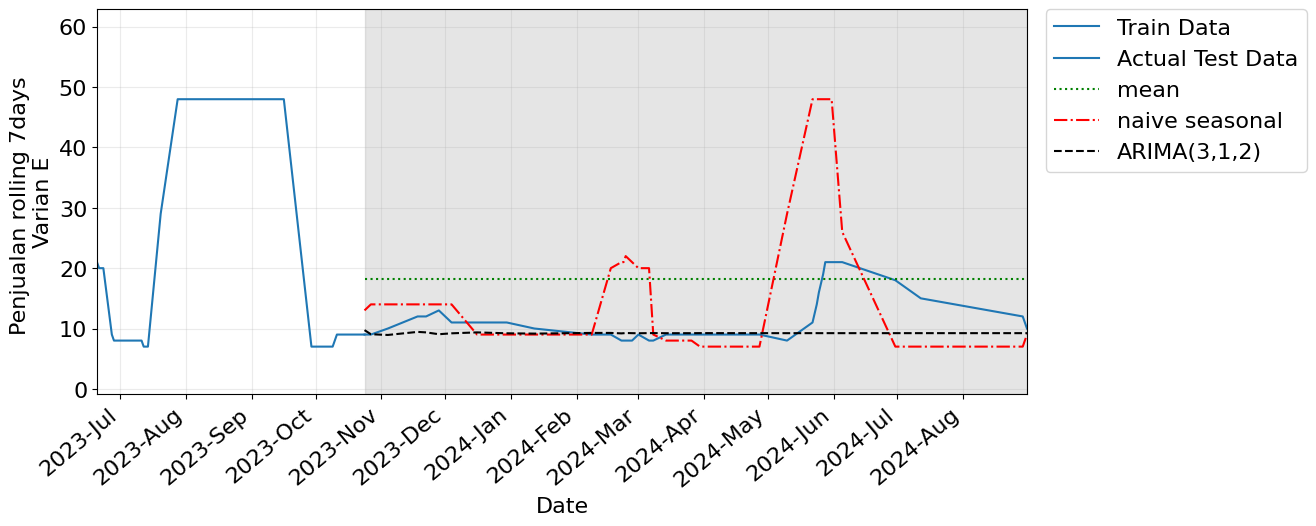

In [55]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 120  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["rolling_7days"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["rolling_7days"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian E")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

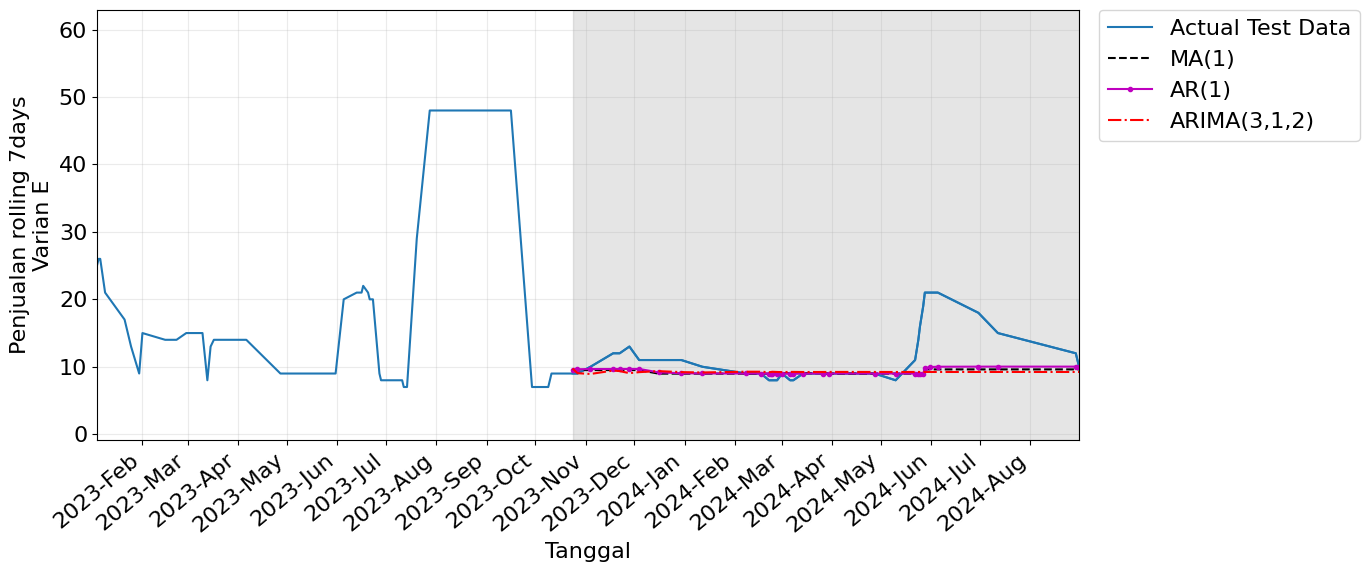

In [56]:
# Gabungkan training cumulative + satu data awal dari test untuk continuity
df_train_cum_extended = pd.concat([df_E_count, df_test_E.iloc[:1]])

start_idx = 90  # Untuk visualisasi lebih fokus
xlim = [df_E_count["Tgl. Mohon"].iloc[start_idx], df_test_E["Tgl. Mohon"].iloc[-1]]

# Mulai plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot data aktual cumulative
ax.plot(df_E_count["Tgl. Mohon"], df_E_count["rolling_7days"])
ax.plot(df_test_E["Tgl. Mohon"], df_test_E["rolling_7days"], label="Actual Test Data", color="tab:blue")

# Plot prediksi MA dan AR untuk cumulative
ax.plot(df_test_E["Tgl. Mohon"], df_test_E["pred_MA"], "k--", label="MA(1)")
ax.plot(df_test_E["Tgl. Mohon"], df_test_E["pred_AR"], "m.-", label="AR(1)")

# Plot prediksi ARIMA
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "r-.", label=f"ARIMA({best_p},{d},{best_q})")

# Forecast area
ax.axvspan(df_test_E['Tgl. Mohon'].iloc[0], df_test_E['Tgl. Mohon'].iloc[-1], color="#808080", alpha=0.2)

# Formatting tanggal di x-axis
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# Pengaturan tambahan
ax.set_xlim(xlim)
ax.grid(True)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan rolling 7days\nVarian E")
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# Rotate x-tick labels
for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


### Evaluasi ARIMA (2,1,1)

MAE

In [57]:
mae_mean           = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_arima"])

print(f"MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"MAE ARIMA: {mae_arima}")

MAE mean: 7.165306122448981
MAE naive seasonal: 10.2
MAE ARIMA: 2.965918910831185


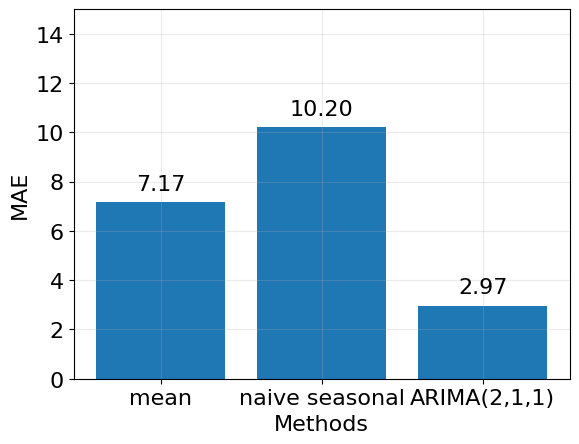

In [58]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [59]:
mse_mean           = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_mean"])
mse_naive_seasonal = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_naive_seasonal"])
mse_arima          = mean_squared_error(df_test_pred_arima["rolling_7days"], df_test_pred_arima["pred_arima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE ARIMA: {mse_arima}")

MSE mean: 60.14387755102042
MSE naive seasonal: 220.25714285714287
MSE ARIMA: 21.503322484467258


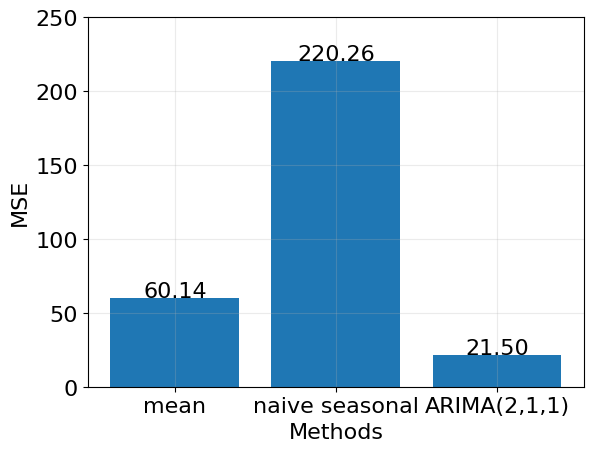

In [60]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mse_mean, mse_naive_seasonal, mse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [61]:
rmse_mean           = np.sqrt(mse_mean)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal}")
print(f"RMSE arima: {rmse_arima }")

RMSE mean: 7.755248387448362
RMSE naive seasonal: 14.841062726676377
RMSE arima: 4.637167506621608


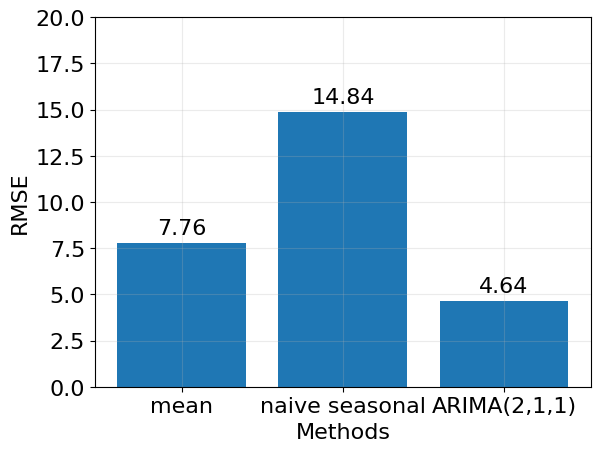

In [62]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [rmse_mean, rmse_naive_seasonal, rmse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [63]:
mape_mean           = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_mean"]) / df_test_pred_arima["rolling_7days"])) * 100
mape_naive_seasonal = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_naive_seasonal"]) / df_test_pred_arima["rolling_7days"])) * 100
mape_arima          = np.mean(np.abs((df_test_pred_arima["rolling_7days"] - df_test_pred_arima["pred_arima"]) / df_test_pred_arima["rolling_7days"])) * 100

print(f"MAPE mean: {mape_mean:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

MAPE mean: 75.14%
MAPE naive seasonal: 86.63%
MAPE ARIMA: 20.15%


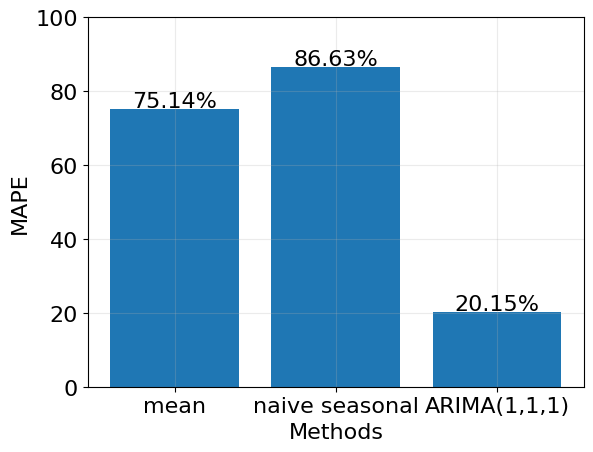

In [64]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 100])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [65]:
naive = np.abs(np.diff(df_test_pred_arima["rolling_7days"])).mean()

mase_mean           = mae_mean_undiff / naive
mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima          = mae_arima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE ARIMA: {mase_arima}")

MASE mean: 2.59422654921885
MASE naive seasonal: 9.372972972972972
MASE ARIMA: 2.7254389991421704


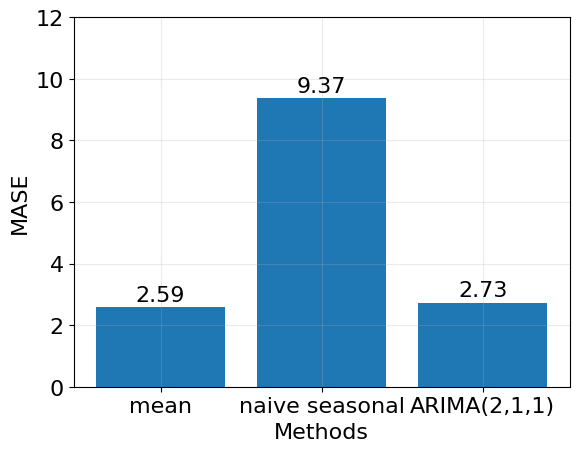

In [66]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mase_mean, mase_naive_seasonal, mase_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 12])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)